# Transfer from walking to other tasks

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from qdax.utils.plotting import plot_2d_map_elites_repertoire
from scipy.stats import ranksums
%matplotlib inline

/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.decl

In [2]:
tasks = ["BridgeWalker-v0", "CustomPusher-v0", "CustomCarrier-v0", "UpStepper-v0", "DownStepper-v0",
         "ObstacleTraverser-v0", "ObstacleTraverser-v1", "Hurdler-v0", "PlatformJumper-v0", "GapJumper-v0",
         "CaveCrawler-v0"
         ]

In [11]:
evo_dfs = []
sampling = "all"
for task in tasks:
    processed_task = task.replace("-v0", "").lower()
    for seed in range(10):
        try:
            tmp_df = pd.read_csv(f"../results/me/evo-body-10x10-{processed_task}-{sampling}_{seed}.csv")
            tmp_df["seed"] = seed
            tmp_df["task"] = task
            tmp_df["sampling"] = "direct_evolution" # sampling
            tmp_df["repertoire"] = "all"
            evo_dfs.append(tmp_df)
        except FileNotFoundError:
            print(task, seed)
evo_df = pd.concat(evo_dfs, ignore_index=True)
evo_df.head()

CaveCrawler-v0 9


,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,seed,task,sampling,repertoire
0,1.0,1.033856,-2.813630,2.786834,-7.729624,1.269531,5.957031,2.636719,23.280643,2024-06-04 19:39:47.713679,0.0,0,BridgeWalker-v0,direct_evolution,all
1,2.0,1.033856,-2.283975,8.642919,-10.980222,1.367188,7.714844,3.222656,13.593169,2024-06-04 19:40:01.307147,0.0,0,BridgeWalker-v0,direct_evolution,all
2,3.0,1.033856,1.529860,15.400932,-9.685629,1.464844,9.082031,3.320312,13.195543,2024-06-04 19:40:14.503131,0.0,0,BridgeWalker-v0,direct_evolution,all
3,4.0,1.033856,1.782396,20.309895,-9.502535,1.464844,9.863281,3.417969,13.382216,2024-06-04 19:40:27.885777,0.0,0,BridgeWalker-v0,direct_evolution,all
4,5.0,1.033856,4.763123,26.261871,-11.015659,1.464844,11.132812,3.808594,13.246979,2024-06-04 19:40:41.133130,0.0,0,BridgeWalker-v0,direct_evolution,all


## Processing time

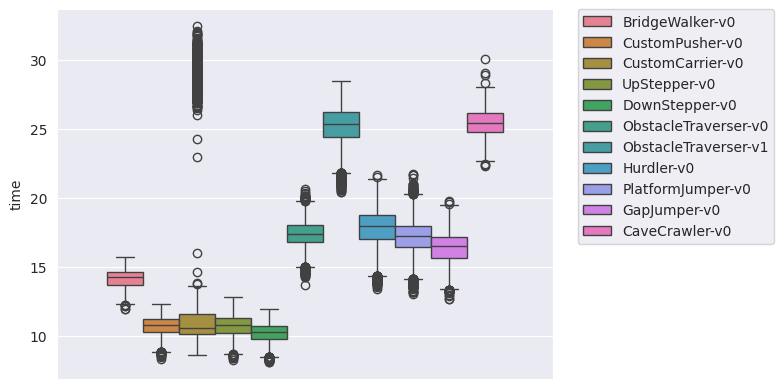

In [4]:
sns.boxplot(
    evo_df[evo_df["iteration"] > 5],
    y="time",
    hue="task",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Evolution results

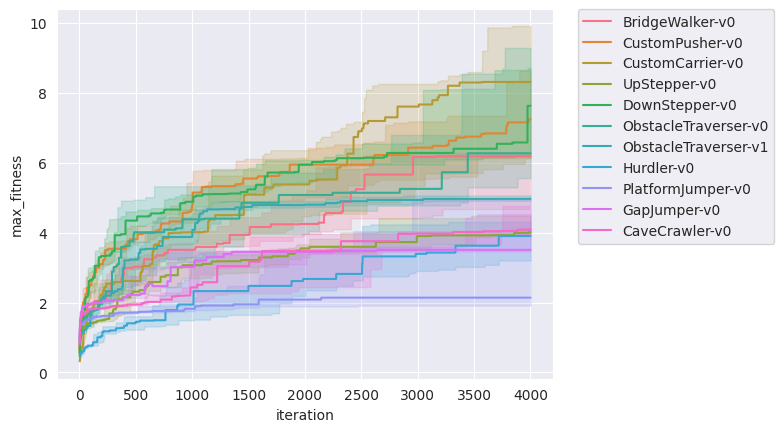

In [5]:
sns.lineplot(
    evo_df,
    x="iteration",
    y="max_fitness",
    hue="task",
    estimator="median",
    errorbar=("pi", 50),
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [12]:
final_evo_df = evo_df[evo_df["iteration"] == max(evo_df["iteration"])][
    ["max_fitness", "coverage1", "coverage2", "coverage3", "task", "seed", "sampling", "repertoire"]]
final_evo_df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.417970,37.988280,BridgeWalker-v0,0,direct_evolution,all
7999,6.262626,16.699219,55.761720,42.871094,BridgeWalker-v0,1,direct_evolution,all
11999,4.975401,21.875000,55.957030,44.433594,BridgeWalker-v0,2,direct_evolution,all
15999,4.113746,16.992188,53.515625,48.046875,BridgeWalker-v0,3,direct_evolution,all
19999,6.284542,19.824219,55.273438,37.109375,BridgeWalker-v0,4,direct_evolution,all


## Task transfer results

In [13]:
dfs = [final_evo_df]
samplings = ["all", "s1", "s2", "s3"]
repertoires = [f"g{i + 1}" for i in range(3)]
for task in tasks:
    for sampling in samplings:
        for rep in repertoires:
            for seed in range(10):
                tmp_df = pd.read_csv(f"../results/transfer/evo-body-10x10-floor-{sampling}_{seed}_{rep}_{task}.csv")
                tmp_df["seed"] = seed
                tmp_df["task"] = task
                tmp_df["sampling"] = sampling
                tmp_df["repertoire"] = rep
                dfs.append(tmp_df)
df = pd.concat(dfs)
df.head()

,max_fitness,coverage1,coverage2,coverage3,task,seed,sampling,repertoire
3999,4.757004,16.699219,53.417970,37.988280,BridgeWalker-v0,0,direct_evolution,all
7999,6.262626,16.699219,55.761720,42.871094,BridgeWalker-v0,1,direct_evolution,all
11999,4.975401,21.875000,55.957030,44.433594,BridgeWalker-v0,2,direct_evolution,all
15999,4.113746,16.992188,53.515625,48.046875,BridgeWalker-v0,3,direct_evolution,all
19999,6.284542,19.824219,55.273438,37.109375,BridgeWalker-v0,4,direct_evolution,all


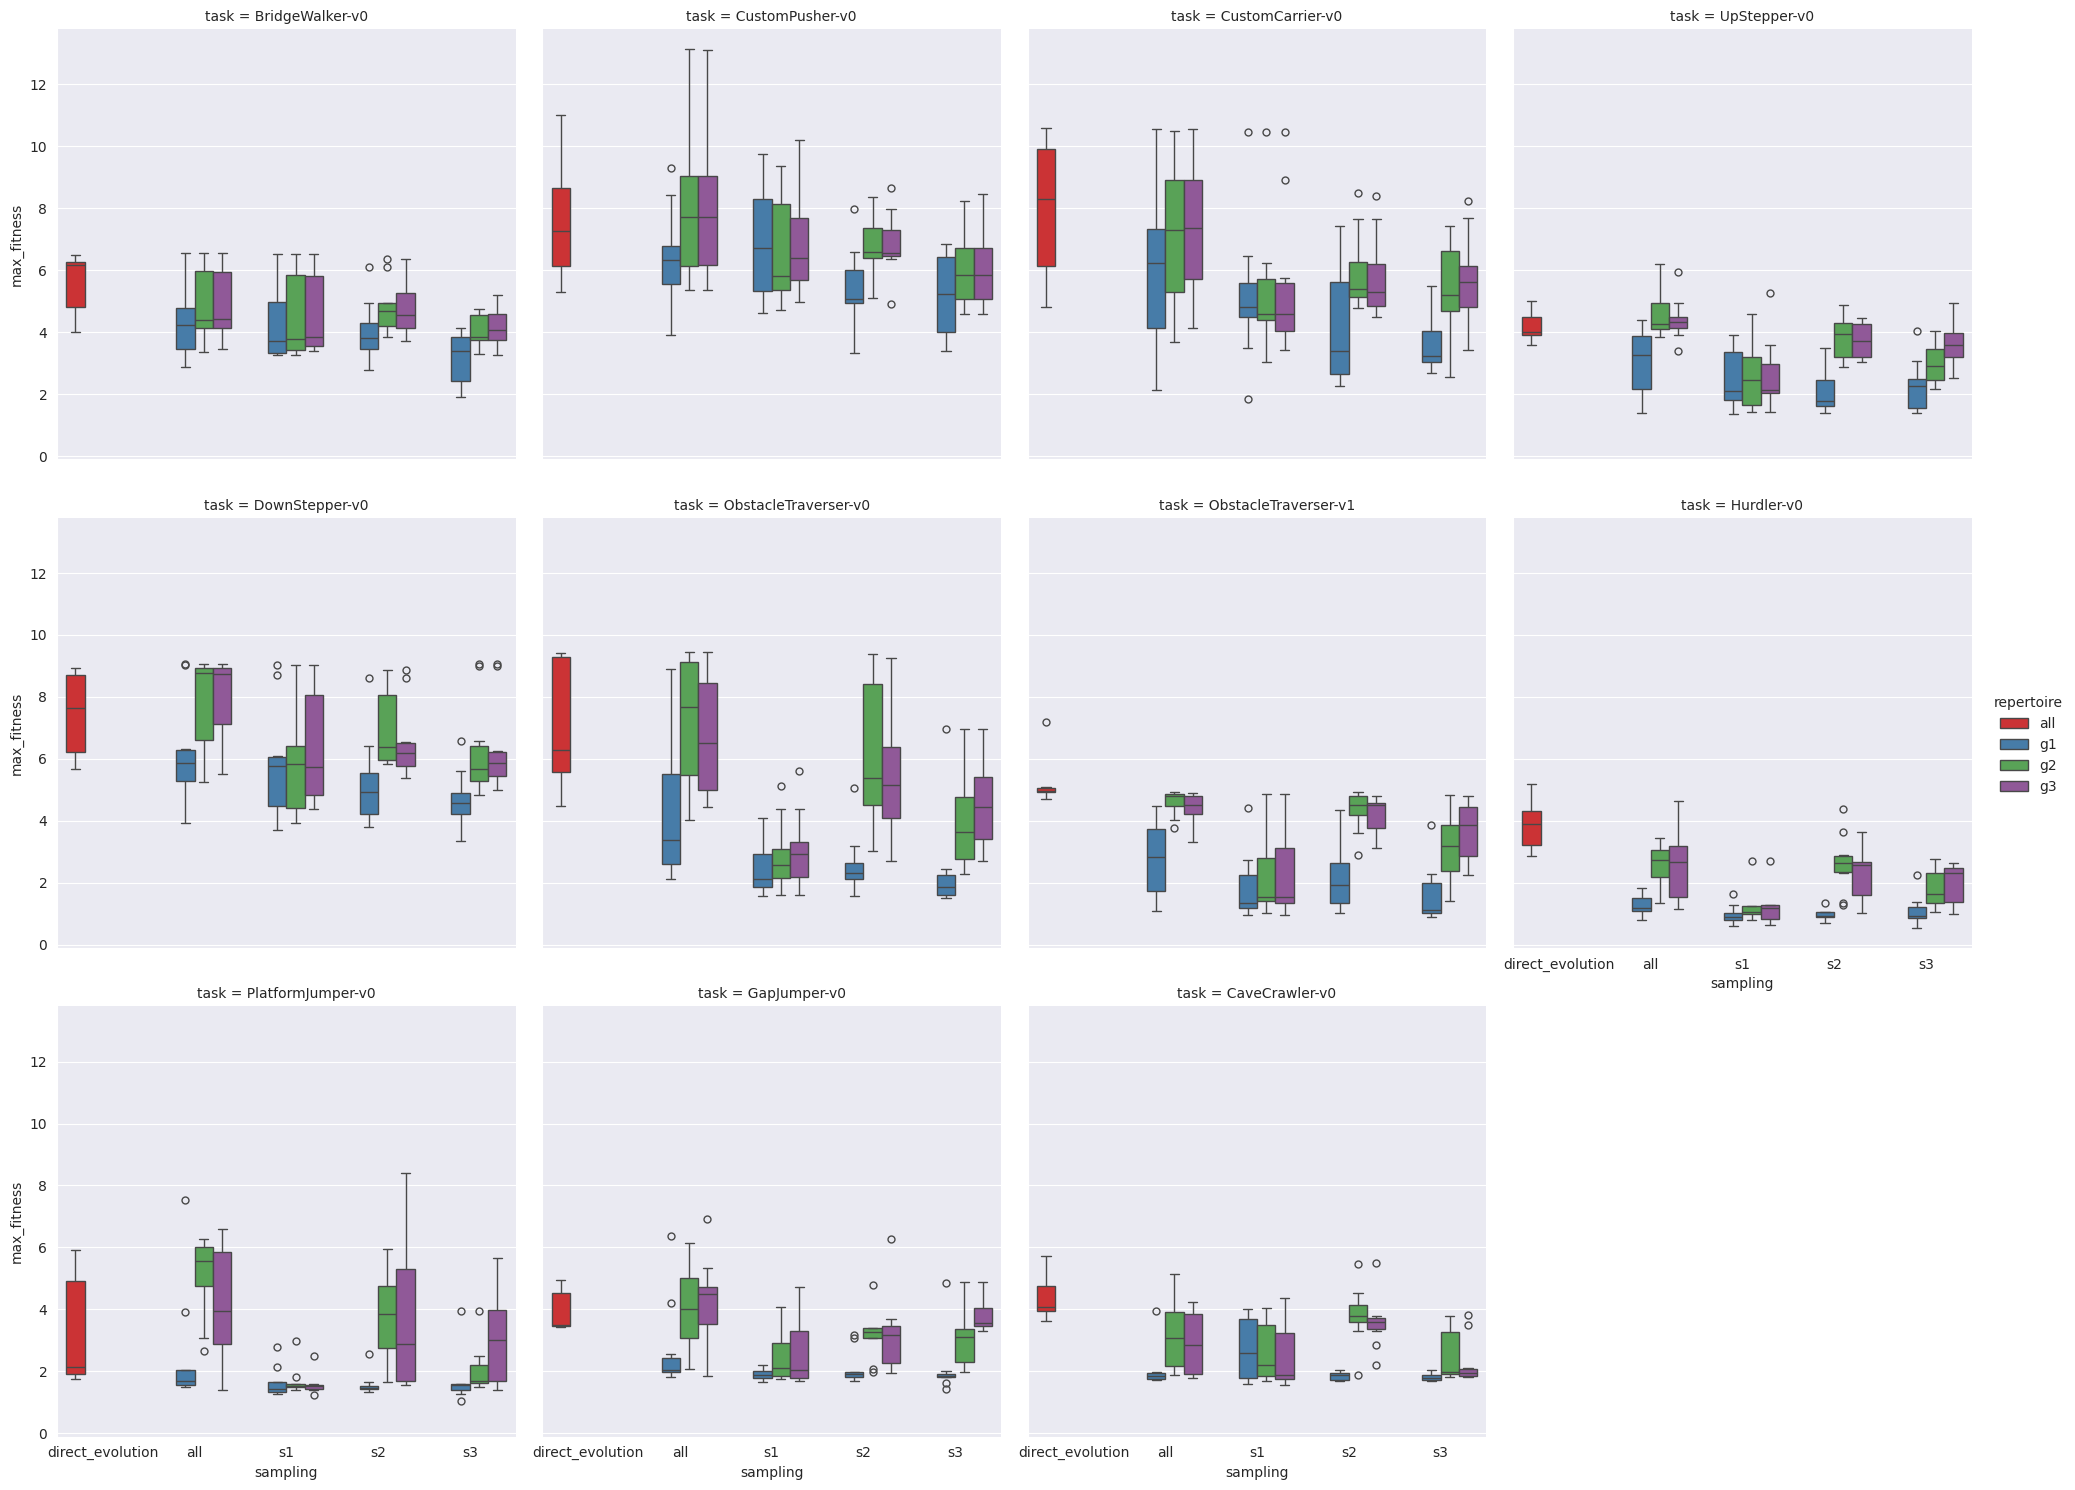

In [14]:
sns.catplot(df,
            x="sampling",
            y="max_fitness",
            col="task",
            col_wrap=4,
            hue="repertoire",
            palette="Set1",
            kind="box",
            )
plt.show()

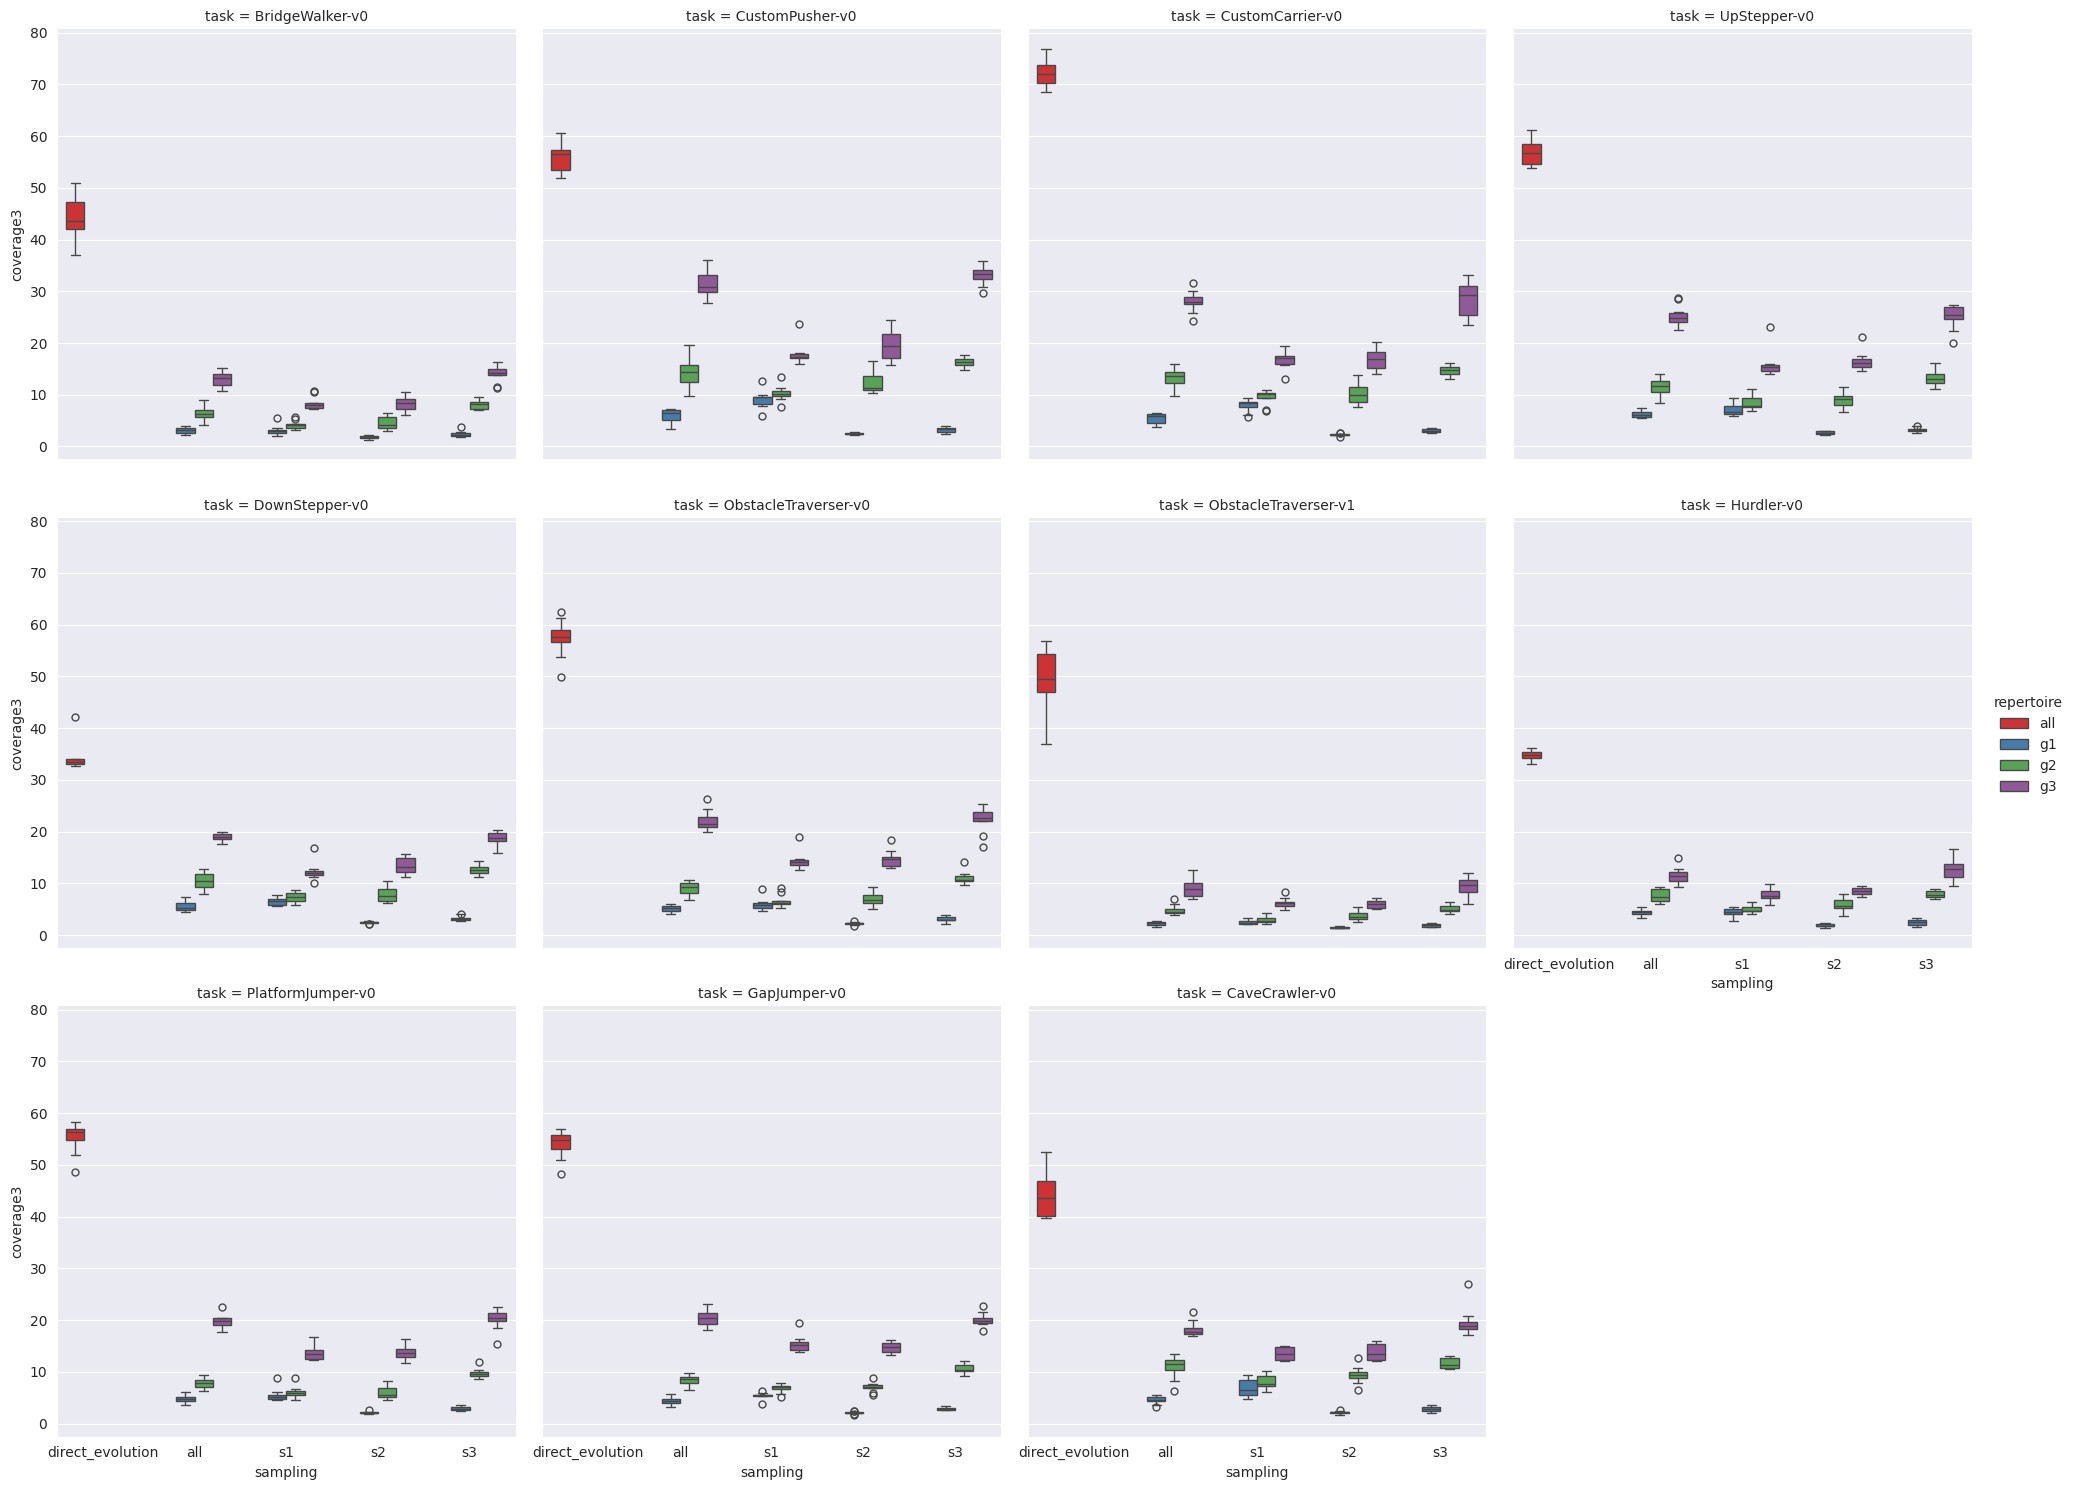

In [15]:
sns.catplot(df,
            x="sampling",
            y="coverage3",
            col="task",
            col_wrap=4,
            hue="repertoire",
            palette="Set1",
            kind="box",
            )
plt.show()